In [1]:
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
import pl_bolts
from relative_performer.train import RelativePerformerModel
import matplotlib.pyplot as plt

In [2]:
import os
os.getcwd()

'/Users/hornm/Projects/RelativePerformer/notebooks'

In [3]:
dataset = pl_bolts.datamodules.MNISTDataModule('../data/MNIST')

In [4]:
train_loader = dataset.train_dataloader()
batch = next(train_loader.__iter__())

In [5]:
x, y = batch
x = x.permute(0, 2, 3, 1)
x = x[[0]]

In [6]:
x.shape

torch.Size([1, 28, 28, 1])

In [35]:
model = RelativePerformerModel(dim=128, heads=1, depth=1, in_features=1, max_pos=28, pos_dims=2, pos_scales=8, num_classes=10, embedding_type='linear', no_projection=True, content_rel_attn=True)

In [36]:
x_flat, positions = model._flatten_to_sequence(x)

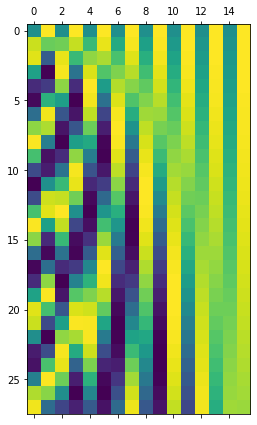

In [37]:
plt.matshow(model._compute_positional_embeddings(positions[:, :28, [1]]).detach().numpy()[0], aspect='auto')

In [38]:
out1 = model(x).detach().numpy()

In [39]:
out2 = model(x_flat, positions).detach().numpy()

In [40]:
out3 = model(x_flat, positions + torch.ones(*positions.shape)).detach().numpy()

In [41]:
np.allclose(out1, out2)

True

In [42]:
np.allclose(out1, out3)

False

In [43]:
out1[0], out3[0]

(array([ 0.19901657, -1.0209535 , -0.5349111 ,  0.40523094, -0.06661904,
        -1.0148358 , -0.7798277 ,  0.5173554 , -0.03173403, -0.1405547 ],
       dtype=float32),
 array([ 0.19884002, -1.0207275 , -0.53496534,  0.40507913, -0.06667282,
        -1.0150121 , -0.77973497,  0.5174498 , -0.03182615, -0.14077346],
       dtype=float32))

In [32]:
positions + torch.ones(*positions.shape)

tensor([[[ 1.,  1.],
         [ 1.,  2.],
         [ 1.,  3.],
         ...,
         [28., 26.],
         [28., 27.],
         [28., 28.]]])

In [33]:
from relative_performer.constrained_relative_encoding import ConstrainedLinear, IdentityLinear

to_q, to_k = ConstrainedLinear(1, 2, 16, 2, content_rel_attn=True), IdentityLinear(1, 2, 16, 2, content_rel_attn=True)

In [34]:
def compute_dot_prod2(i1, i2, j1, j2):
    positions = torch.Tensor([[i1, i2], [j1, j2], [i1, i2]])[None]
    from einops import rearrange
    encodings = model._compute_positional_embeddings(positions)
    fake_data = torch.zeros(1, 3, 1)
    q = to_q(fake_data, encodings)
    k = to_k(fake_data, encodings)
    print(q.shape)
    return q.matmul(k.transpose(-1, -2))
# print(compute_dot_prod(0, 0, 1, 1))
print(compute_dot_prod2(0, 0, 1, 1))
print(compute_dot_prod2(1, 1, 2, 2))

torch.Size([1, 2, 3, 65])
tensor([[[[-3.7082, -4.9910, -3.7082],
          [-2.8502, -3.7082, -2.8502],
          [-3.7082, -4.9910, -3.7082]],

         [[-3.2733, -4.2058, -3.2733],
          [-1.9385, -3.2733, -1.9385],
          [-3.2733, -4.2058, -3.2733]]]], grad_fn=<UnsafeViewBackward>)
torch.Size([1, 2, 3, 65])
tensor([[[[-3.7082, -4.9910, -3.7082],
          [-2.8502, -3.7082, -2.8502],
          [-3.7082, -4.9910, -3.7082]],

         [[-3.2733, -4.2058, -3.2733],
          [-1.9385, -3.2733, -1.9385],
          [-3.2733, -4.2058, -3.2733]]]], grad_fn=<UnsafeViewBackward>)
